# Hydrologische Modelle - Übung 6

## Vorgehensweise

Sie befinden sich hier in einem Jupyter Notebook, auf welchem Sie Matlab-Code ausführen können. Bitte lesen Sie sich die folgenden Hinweise zur Nutzung dieses Notebooks gut durch.

* bitte schreiben Sie Ihren Code entsprechend der jeweiligen Übungsaufgabe in das Feld unter der Aufgabe
* Ihren Code führen Sie hier (in Jupyter Notebooks) durch die Tastenkombination Shift + Enter im jeweiligen Codeblock aus
* Die Lösung zur Aufgabe kann durch einen Klick auf die drei Punkte unter "Lösung:" eingesehen werden. Bitte werfen Sie erst einen Blick in die Lösungen, wenn Ihr Code entweder läuft oder sie alles probiert haben, was Ihnen als Lösungsweg einfällt (Sie verderben sich sonst selbst den ganzen Knobelspaß und das Erfolgserlebnis am Ende ;-) ). Oft hilft ein Blick in die PDF zur jeweiligen Übung oder auch Google.
* Code-Blöcke und ihr Output lassen sich in Jupyter Notebooks durch einen Klick auf den linken blauen Balken ausblenden.
* Oftmals gibt es nicht nur DEN einen Weg in Matlab (und anderen Programmiersprachen) - probieren Sie ruhig alles aus! Viel können Sie hier nicht kaputt machen. ;-)

In dem Sinne viel Spaß!

## Inhalte
* Formaler Test der Modellierung einer Einheitsganglinie mit Beispieldaten aus Singh (1976)
* Test der Modellierung einer Einheitsganglinie mit weiteren Beispieldatensätzen

## Formaler Test der Modellierung einer Einheitsganglinie mit Beispieldaten aus Singh (1976)

#### 1. Erstellen Sie den Datensatz nach folgenden Anweisungen:  
* Führen Sie den ersten Codeblock aus. Dieser erstellt die Datenbasis, mit der Sie arbeiten.  
* Definieren sie den Korrekturfaktor *CorrFactor* als Relation der Niederschlagssumme zur Durchflusssumme: 
$\frac{Summe P} {Summe Q}$
* Wenden Sie diesen Korrekturfaktor multiplikativ auf die Durchflussmatrix *q* an  
* Berechnen Sie die Anzahl der Elemente von q und p als *NumQ* und *NumP*
* Berechnen sie die Anzahl der Elemente der Einheitsganglinie H als *NumH* (Tipp: hier Anzahl der Schritte vom letzten Niederschlagswert (inklusive) bis zum letzten Durchflusswert)
* Zuletzt erstellen Sie einen Zeitvektor (Spaltenvektor) *t* der Länge $NumQ + 1$

In [5]:
inch_in_mm = 25.4;
p = [0.12; 0.88; 0.8; 1.0; 0.24]*inch_in_mm;
q = [0.003; 0.011; 0.036; 0.09; 0.14; 0.14; 0.11; 0.082; 0.057;...
     0.037; 0.025; 0.014; 0.008; 0.004; 0.002; 0.001]*inch_in_mm;

Lösung:

In [6]:
CorrFactor = sum(p)/sum(q);
q = q*CorrFactor;

NumQ = numel(q);
NumP = numel(p);
NumH = NumQ-NumP+1;

t = (0:NumQ+1)';

#### 2. Erstellen Sie die Koeffizientenmatrix von P, indem Sie zuerst eine Nullmatrix der Größe (*NumQ*, *NumH*) als *P* definieren und anschließend spaltenweise das Niederschlagsereignis *p* wie in  **UnitHydrographFolien.pdf** Folie 11 einfügen. 

Lösung: 

In [7]:
P = zeros(NumQ,NumH);
for i = 1:NumH
    P(i:i+NumP-1,i) = p;
end

#### 3.  Das Erstellen der notwendigen Unterfunktionen *UH_objfun* und *UH_confun* zum Finden der Näherungslösung für die Einheitsganglinie:  
  
#### UH_objfun:  
  
Erstellen Sie die Zielfunktion *UH_objfun*, die die drei Arrays *x*, *q* und *P* folgendermaßen umwandelt (Das Ergebnis ist der Output der Funktion):  
$ \sum (P*x - q)^2 $  
  
#### UH_confun:  
  
Erstellen Sie die Funktion *UH_confun*, welche die Bedingungen für den späteren Optimierungsalgorithmus anhand eines Eingabevektors *x* folgendermaßen definiert (*c* und *ceq* sind der Output von *UH_confun*):  
  
  * Für die nichtlinearen Ungleichheitsbedingungen:  
      1. Finden des Maximums auf x (Index!)  
      2. Definition des folgenden Arrays *c*:  
  
          in der ersten Zeile: der schrittweise Anstieg bis zum Maximum von *x*, aber mit negativem Vorzeichen  
          in der zweiten Zeile: der schrittweise Abstieg ab dem Maximum von *x*, aber mit positivem Vorzeichen  
          in der dritten Zeile: *x* mit negativem Vorzeichen    
  
  * Für die nichtlinearen Gleichheitsbedingungen:
      1. Definition des Skalars $ \sum(x)  -1$ als *ceq*  

Lösung UH_objfun:

In [8]:
%%file UH_objfun_loesung.m
% Zielfunktion der Einheitsganglinie

function f = UH_objfun_loesung(x, q, P)

f = sum((P*x-q).^2);

end

Created file '/projects/p076/p_hydromodelle/Git_hydromodelle/Uebung_6/UH_objfun_loesung.m'.


Lösung UH_confun:

In [9]:
%%file UH_confun_loesung.m
% Nebenbedingungen für den Optimierungsalgorithmus

function [c, ceq] = UH_confun_loesung(x)
% Nonlinear inequality constraints
[~,idx] = max(x);
c = [x(1:idx-1)-x(2:idx); x(idx+1:end)-x(idx:end-1); 0-x];

% Nonlinear equality constraints
ceq = sum(x)-1;
end

Created file '/projects/p076/p_hydromodelle/Git_hydromodelle/Uebung_6/UH_confun_loesung.m'.


#### 4. Optimierung der Ganglinie (Hydrograph) h durch verschiedene Methoden:  
  
1. Lösen Sie die Gleichung $ q = P * h $ nach h mit der kleinste-Fehlerquadrate-Methode (Tipp: https://de.mathworks.com/help/matlab/ref/mldivide.html) --> benennen Sie h mit *h1*  
2. Lösen sie diese Gleichung als **nicht-negatives** lineares kleinste-Fehlerquadrate-Problem (Tipp: https://de.mathworks.com/help/matlab/ref/lsqnonneg.html) --> benennen Sie h  mit *h2*  
3. Lösen sie diese Gleichung mit einem Optimierungsalgorithmus für nichtlineare multivariable Funktionen mit Nebenbedingungen (Tipps: https://de.mathworks.com/help/optim/ug/fmincon.html; x0 ist eine Einsmatrix mit den Ausmaßen der späteren Einheitsganglinie; es existieren für diesen Fall keine weiteren Nebenbedingungen außer jene in **UH_confun**). Nutzen Sie hierfür die von Ihnen vorbereitete Zielfunktion *UH_objfun* und die Funktion für die Nebenbedingungen *UH_confun* --> benennen Sie h mit *h3*

Lösung:

In [11]:
h1 = P\q;
h2 = lsqnonneg(P,q);
objfun = @(x) UH_objfun_loesung(x, q, P);
confun = @(x) UH_confun_loesung(x);
h3 = fmincon(objfun, ones(NumH,1),[],[],[],[],[],[],confun);


Local minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the value of the optimality tolerance,
and constraints are satisfied to within the value of the constraint tolerance.



#### 4. Plotten Sie in einem Subplot auf der linken Seite Ihre drei Einheitsganglinien und auf der rechten Seite die mit der optimierten Einheitsganglinie *h3* modellierten Ergebnisse für die Singh-Daten.

Lösung:

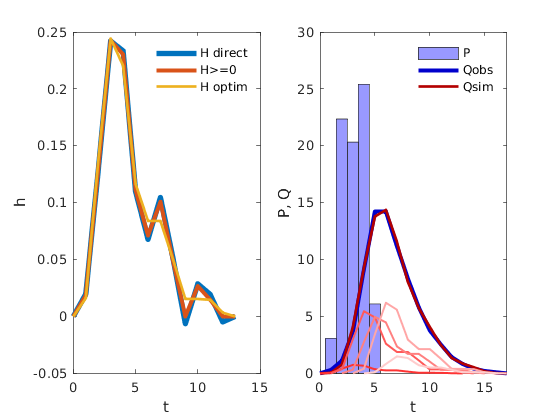

In [12]:
figure(1)
clf

subplot(1,2,1)
plot(0:(NumH+1),[0; h1; 0],'linewidth',4)
hold on
plot(0:(NumH+1),[0; h2; 0],'linewidth',3)
plot(0:(NumH+1),[0; h3; 0],'linewidth',2)
hold off
legend('H direct','H>=0','H optim','location','northeast')
legend('boxoff')
xlabel('t')
ylabel('h')

subplot(1,2,2)
Qsim = P*h3;
h = bar(1-0.5:NumP-0.5,p,'histc');
set(h,'facecolor',[.6,.6,1])
hold on
plot(t,[0; q; 0],'-','color',[0,0,.8],'linewidth',3)
plot(t,[0; Qsim; 0],'-','color',[.7,0,0],'linewidth',2)
colors = ones(NumP,3);
colors(:,2) = linspace(.2,.8,NumP);
colors(:,3) = colors(:,2);
for i = 1:NumP
    tsingle = i:i+NumH-1;
    Qsingle = p(i)*h3;
    plot([i-1 tsingle i+NumH],[0; Qsingle; 0],'-','color',colors(i,:),'linewidth',1.5)
end
hold off
xlim([0, max(t)])
legend('P','Qobs','Qsim','location','northeast')
legend('boxoff')
set(gca,'xtickmode','auto')
xlabel('t')
ylabel('P, Q')

#### 5. Lassen Sie sich die Summe jeder Einheitsganglinie und den Gesamtdurchfluss der beobachteten und simulierten Ganglinie direkt im Command Window bzw. unter dem nächsten Eingabefeld ausgeben.

Lösung:

In [13]:
fprintf('\tsum(h1) = %.4f\n',sum(h1))
fprintf('\tsum(h2) = %.4f, h>=0\n',sum(h2))
fprintf('\tsum(h3) = %.4f, h>=0, sum(h)=1, increase-peak-decrease\n',sum(h3))
fprintf('\tsum(Qobs) = %.2f\n',sum(q))
fprintf('\tsum(Qsim) = %.2f\n',sum(Qsim))

	sum(h1) = 0.9940
	sum(h2) = 0.9953, h>=0
	sum(h3) = 1.0000, h>=0, sum(h)=1, increase-peak-decrease
	sum(Qobs) = 77.22
	sum(Qsim) = 77.22


## Test der Modellierung einer Einheitsganglinie mit weiteren Beispieldatensätzen  

#### Varianten:
* 'Singh': das Singh-Beispiel aus dem ersten Teil der Übung  
* 'triangle4': Dreiecksdurchfluss mit vier Ordinaten  
* 'triangle5': Dreiecksdurchfluss mit fünf Ordinaten  
* 'square': Durchfluss mit einem symmetrischen Quadratgesetz  
* 'Wesenitz': Beispieldurchfluss der Wesenitz am Pegel Elbersdorf

#### Durchführung:  
1. In dem folgenden ersten vorgefertigten Codefeld geben Sie als Variable *variant* den Beispieldatensatz als String an, der Sie interessiert.   
2. Anschließend führen sie das zweite Codefeld aus, um die neue, angepasste Funktion **UH_confun2.m** zu erstellen.
3. Nun können Sie auch das dritte Codefeld ausführen, welches die Einheitsganglinie und die Durchflüsse für die neuen Beispieldatensätze modelliert.  

Codeblock 1 und 3 können Sie für alle fünf Datensätze wiederholen und die verschiedenen Ergebnisse am Ende vergleichen.

Schauen Sie sich außerdem gern einmal den Code in Ruhe an und versuchen Sie, ihn Schritt für Schritt nachzuvollziehen.

In [30]:
clear

variant = 'Singh';  % choose variant here!
% -----------------------------------------

if strcmpi(variant,'Singh')
    % data example from Singh
    inch_in_mm = 25.4;
    p = [0.12; 0.88; 0.8; 1.0; 0.24]*inch_in_mm;
    q = [0.003; 0.011; 0.036; 0.09; 0.14; 0.14; 0.11; 0.082; 0.057;...
         0.037; 0.025; 0.014; 0.008; 0.004; 0.002; 0.001]*inch_in_mm;
    CorrFactor = sum(p)/sum(q);
    q = q*CorrFactor;
    NumQ = numel(q);
    NumP = numel(p);
    t = (1:NumQ)';
    SumMark = 1;
elseif strcmpi(variant,'Wesenitz')
    % data example from July 2010 at Wesenitz/Elbersdorf
    tmp = dlmread('WesenitzElbersdorf_PQ.txt','\t',1,0);
    idx1p = find(tmp(:,5)>0,1,'first');
    idx2p = find(tmp(:,5)>0,1,'last');
    p = tmp(idx1p:idx2p,5);
    idx1q = find(tmp(:,6)>0,1,'first');
    q = tmp(idx1q:end,6);
    NumQ = numel(q);
    NumP = numel(p);
    t = (1:NumQ)';
    SumMark = 0;
else
    % synthetic precipitation and discharge
    % NumQ, NumP and maxQ can be changed
    NumQ = 16;
    NumP = 5;
    maxQ = 10;
    t = (1:NumQ)';
    if strcmpi(variant,'triangle4')
        % triangle discharge for a standard form
        Qstd = [0 0 ; 1/3 1 ; 2/3 .5 ; 1 0];
        Qstd(:,1) = Qstd(:,1)*(NumQ+1);
        Qstd(:,2) = Qstd(:,2)*maxQ;
        q = interp1(Qstd(:,1),Qstd(:,2),t);
    elseif strcmpi(variant,'triangle5')
        % triangle discharge for a standard form
        Qstd = [0 0 ; 1/4 1 ; 2/4 .67 ; 3/4 .33 ; 1 0];
        Qstd(:,1) = Qstd(:,1)*(NumQ+1);
        Qstd(:,2) = Qstd(:,2)*maxQ;
        q = interp1(Qstd(:,1),Qstd(:,2),t);
    elseif strcmpi(variant,'square')
        % equation q = a(t+b)^2+c
        % It must be NumQ ordinates different from zero. Therefor use NumQ+1.
        a = -4*maxQ/(NumQ+1)^2;
        b = -(NumQ+1)/2;
        c = maxQ;
        q = a*(t+b).^2 + c;
    end
    
    p = rand(NumP,1);
    p = p/sum(p)*sum(q); % effective precipitation
    SumMark = 1;
end

NumH = NumQ-NumP+1;
tall = [0; t; NumQ+1]; % t for preceding and following zero discharge

In [22]:
%%file UH_confun2.m

function [c, ceq] = UH_confun2(x, SumMark)
% Nonlinear inequality constraints

[~,idx] = max(x);
c = [x(1:idx-1)-x(2:idx); x(idx+1:end)-x(idx:end-1); 0-x];

% Nonlinear equality constraints
if SumMark==1
    ceq = sum(x)-1;
else
    ceq = 0;
end

Created file '/projects/p076/p_hydromodelle/Git_hydromodelle/Uebung_6/UH_confun2.m'.



Local minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the value of the optimality tolerance,
and constraints are satisfied to within the value of the constraint tolerance.

	sum(H) = 0.9940
	sum(H) = 0.9953, H>=0
	sum(H) = 1.0000, H>=0, sum(H)=1, increase-peak-decrease
	sum(Qobs) = 77.22
	sum(Qsim) = 77.22


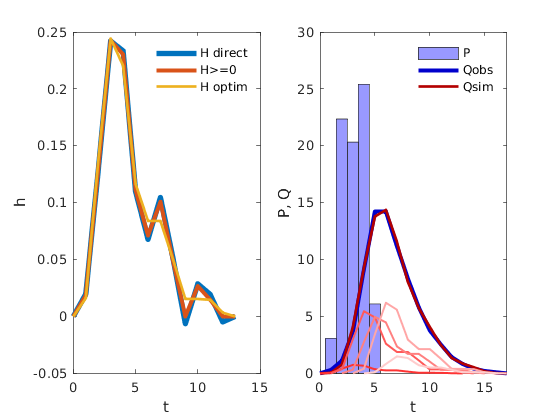

In [31]:
%% get P-matrix (coefficient matrix)
P = zeros(NumQ,NumH);
for i = 1:NumH
    P(i:i+NumP-1,i) = p;
end

%% optimize h
% * h1: least squares
% * h2: nonnegative least squares
% * h3: optimisation with constraints
h1 = P\q;
h2 = lsqnonneg(P,q);
objfun = @(x) UH_objfun_loesung(x, q, P);
confun = @(x) UH_confun2(x, SumMark);
h3 = fmincon(objfun, ones(NumH,1),[],[],[],[],[],[],confun);

%% plotting
% The left figure shows the unit hydrograph in three variants and the right
% figure shows the modeled result for Singh-data using optimised unit
% hydrograph (h3).

figure(1)
clf

subplot(1,2,1)
plot(0:(NumH+1),[0; h1; 0],'linewidth',4)
hold on
plot(0:(NumH+1),[0; h2; 0],'linewidth',3)
plot(0:(NumH+1),[0; h3; 0],'linewidth',2)
hold off
legend('H direct','H>=0','H optim','location','northeast')
legend('boxoff')
xlabel('t')
ylabel('h')

subplot(1,2,2)
Qsim = P*h3;
h = bar(1-0.5:NumP-0.5,p,'histc');
set(h,'facecolor',[.6,.6,1])
hold on
plot(tall,[0; q; 0],'-','color',[0,0,.8],'linewidth',3)
plot(tall,[0; Qsim; 0],'-','color',[.7,0,0],'linewidth',2)
colors = ones(NumP,3);
colors(:,2) = linspace(.2,.8,NumP);
colors(:,3) = colors(:,2);
for i = 1:NumP
    tsingle = i:i+NumH-1;
    Qsingle = p(i)*h3;
    plot([i-1 tsingle i+NumH],[0; Qsingle; 0],'-','color',colors(i,:),'linewidth',1.5)
end
hold off
xlim([0, max(tall)])
legend('P','Qobs','Qsim','location','northeast')
legend('boxoff')
set(gca,'xtickmode','auto')
xlabel('t')
ylabel('P, Q')


%% writing some output to cmd-window
% Show sum of each unit hydrograph and overall mass of observed and
% simulated runoff.

fprintf('\tsum(H) = %.4f\n',sum(h1))
fprintf('\tsum(H) = %.4f, H>=0\n',sum(h2))
fprintf('\tsum(H) = %.4f, H>=0, sum(H)=1, increase-peak-decrease\n',sum(h3))
fprintf('\tsum(Qobs) = %.2f\n',sum(q))
fprintf('\tsum(Qsim) = %.2f\n',sum(Qsim))